In [1]:
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import numpy as np
import datetime
import calendar
import cartopy.crs as ccrs
import netCDF4 as nc
import pandas as pd

In [2]:
gfed_2018 = xr.open_dataset("gfed_data/GFED4.1s_2018_beta.hdf5")

In [3]:
lat_array = gfed_2018.lat.values[:, 0]
lon_array = gfed_2018.lon.values[0, :]
time_2018 = np.arange('2018-01', '2019-01', dtype='datetime64[D]')

Import dataset and reconstruct it to gridded dataset of time, lat, lon

In [4]:
nc2018 = nc.Dataset("gfed_data/GFED4.1s_2018_beta.hdf5")

In [50]:
nc2018.groups['emissions'].groups['01'].variables['C']

<class 'netCDF4._netCDF4.Variable'>
float32 C(phony_dim_8, phony_dim_9)
    long_name: GFED4s biomass burning carbon emissions
    units: g C / m^2 / month
path = /emissions/01
unlimited dimensions: 
current shape = (720, 1440)
filling off

In [5]:
lat_array = np.array(nc2018.variables['lat'])[:, 0]
lon_array = np.array(nc2018.variables['lon'])[0, :]
time_2018 = np.arange('2018-01', '2019-01', dtype='datetime64[D]')

Using daily fraction, split monthly emission into daily emission

In [6]:
year = 2018
C_2018 = None
for month in range(1, 13):
    nc_2018_mo = nc2018.groups['emissions'][str(month).zfill(2)]
    nc_2018_mo_C = np.array(nc_2018_mo.variables['C'])
    last_day = calendar.monthrange(year,month)[1]
    daily_fraction = np.empty((last_day,) + nc_2018_mo_C.shape)
    for day in range(1, last_day+1):
        daily_fraction[day-1,:,:] = np.array(nc_2018_mo.groups['daily_fraction'].variables['day_'+str(day)])
    month_C = nc_2018_mo_C * daily_fraction
    if C_2018 is None:
        C_2018 = month_C
    else:
        C_2018 = np.concatenate((C_2018, month_C), axis=0)

Check if the shape of the dataset is (time, lat, lon)

In [7]:
C_2018.shape

(365, 720, 1440)

Construct dataset with three coordinates

In [8]:
C_emission_2018 = xr.Dataset(
    {
        "carbon_emission": (["time", "lat", "lon"], C_2018),
    },
    coords={
        "time": time_2018,
        "lat": lat_array,
        "lon": lon_array,
    },
)

Plot on the world map for test

Text(0.5, 1.0, 'surface carbon emission')

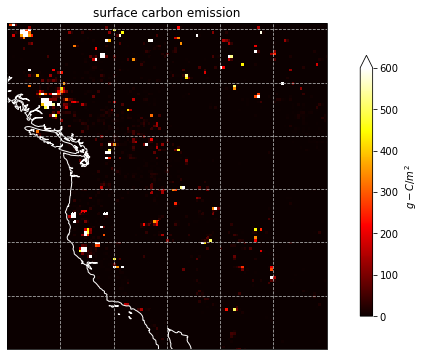

In [52]:
x1, x2, y1, y2 = (-130, -100, 60, 30)
fig = plt.figure(figsize=[12, 6])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(color='white')
ax.gridlines(linestyle='--')
ax.set_extent((x1, x2, y1, y2))
dr = C_emission_2018['carbon_emission'].sum(dim='time')
dr.plot(ax=ax, vmin=0, vmax=600, cmap=plt.get_cmap('hot'), cbar_kwargs={'shrink': 0.8, 'label': '$g-C / m^2$'})
ax.set_title('surface carbon emission')

In [29]:
xx = np.arange(x1, x2, 5)
yy = np.arange(y1, y2, -5)
xx, yy

(array([-130, -125, -120, -115, -110, -105]), array([60, 55, 50, 45, 40, 35]))

In [69]:
dr = C_emission_2018['carbon_emission']
dr.coords

Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * lat      (lat) float32 89.875 89.625 89.375 ... -89.375 -89.625 -89.875
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875

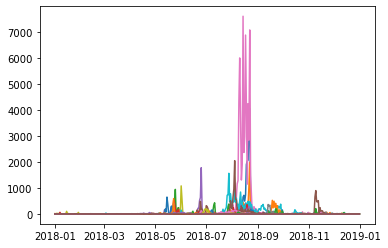

In [119]:
for i, y in enumerate(yy):
    for j, x in enumerate(xx):
        agg_data[i][j] = dr.loc[:, y:y-5, x:x+5].sum(dim=['lat', 'lon'])
        plt.plot(time_2018, agg_data[i][j], label=(i,j))
plt.show()

Ozone dataset

In [172]:
o3 = pd.read_csv("openaq_data/o3.csv", parse_dates=['utc', 'local'], index_col=[0])
o3.head()

,location,city,country,utc,local,parameter,value,unit,latitude,longitude,attribution
1,La Casa NCORE - 4545,Denver-Aurora,US,2018-12-31 00:00:00+00:00,2018-12-30 17:00:00-07:00,o3,0.016,ppm,39.779400,-105.005230,"[{""url"":""http://www.airnow.gov/"",""name"":""US EP..."
3,Highland Reservoir -,Denver-Aurora,US,2018-12-31 00:00:00+00:00,2018-12-30 17:00:00-07:00,o3,0.017,ppm,39.568900,-104.957200,"[{""url"":""http://www.airnow.gov/"",""name"":""US EP..."
6,Chatfield Park - 115,Denver-Aurora,US,2018-12-31 00:00:00+00:00,2018-12-30 17:00:00-07:00,o3,0.033,ppm,39.533900,-105.070000,"[{""url"":""http://www.airnow.gov/"",""name"":""US EP..."
8,Denver - CAMP - 2105,Denver-Aurora,US,2018-12-31 00:00:00+00:00,2018-12-30 17:00:00-07:00,o3,0.019,ppm,39.751099,-104.987198,"[{""url"":""http://www.airnow.gov/"",""name"":""US EP..."
9,Rocky Flats - N - 16,Denver-Aurora,US,2018-12-31 00:00:00+00:00,2018-12-30 17:00:00-07:00,o3,0.042,ppm,39.912800,-105.188300,"[{""url"":""http://www.airnow.gov/"",""name"":""US EP..."


In [101]:
mean_df = o3.groupby(['location', pd.Grouper(key="utc", freq="D")]).mean()
mean_df

value  latitude  longitude
location             utc                                                     
Aspen Park           2018-04-19 00:00:00+00:00  0.042500   39.5415  -105.2984
                     2018-04-20 00:00:00+00:00  0.039667   39.5415  -105.2984
                     2018-04-21 00:00:00+00:00  0.037000   39.5415  -105.2984
                     2018-04-22 00:00:00+00:00  0.037750   39.5415  -105.2984
                     2018-04-23 00:00:00+00:00  0.048857   39.5415  -105.2984
...                                                  ...       ...        ...
Welch - 12400 W. Hwy 2018-12-12 00:00:00+00:00  0.032692   39.6389  -105.1389
                     2018-12-13 00:00:00+00:00  0.015000   39.6389  -105.1389
                     2018-12-17 00:00:00+00:00  0.030000   39.6389  -105.1389
                     2018-12-24 00:00:00+00:00  0.031000   39.6389  -105.1389
                     2018-12-28 00:00:00+00:00  0.022429   39.6389  -105.1389

[1839 rows x 3 columns]

In [137]:
start_end_idx = np.dstack((np.where(np.diff(np.sign(agg_data[1][0]))==1), np.where(np.diff(np.sign(agg_data[1][0]))==-1))).reshape((-1, 2))

array([[166, 168],
       [169, 171],
       [172, 173],
       [190, 194],
       [195, 196],
       [200, 201],
       [202, 204],
       [206, 249],
       [264, 266],
       [269, 272],
       [276, 277],
       [280, 281],
       [282, 284],
       [286, 289],
       [290, 292],
       [295, 299],
       [300, 303],
       [304, 305],
       [306, 307],
       [308, 314],
       [315, 322],
       [323, 327],
       [330, 331],
       [332, 333],
       [335, 338],
       [340, 341],
       [342, 346]])

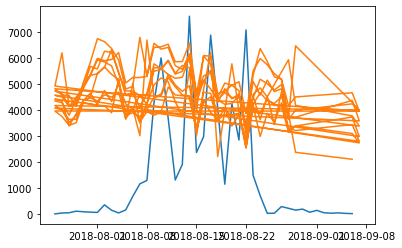

In [174]:
plt.plot(time_2018[206:249], agg_data[1][0][206:249])
df_select = mean_df.loc[pd.IndexSlice[:, time_2018[206]:time_2018[249]],:]
plt.plot(df_select.index.get_level_values("utc"), df_select.value*100000)

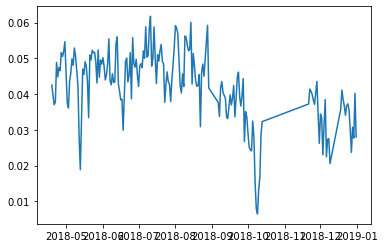

In [112]:
plt.plot(mean_df.loc[("Aspen Park",)]['value'])

Sample interpolation

In [72]:
example_row = o3.iloc[0]
example_row.utc.date()

datetime.date(2018, 10, 13)

In [88]:
dr_C = C_emission_2018['carbon_emission']
dr_C.interp(lat=example_row.latitude, lon=example_row.longitude)

<xarray.DataArray 'carbon_emission' (time: 365)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
    lat      float64 39.74
    lon      float64 -105.2